Set the path where the csv file is located, then import all necessary libs.

In [1]:
csv_file = "/home/quinton/Documents/Projects/COMET_Prestudy/scripts/collection/formal_scripts/output_data_mlab_01_2017.tsv" # **PLACE CSV FILEPATH HERE**

import pandas as pd
import nltk

Load csv data into the program. Show head data to verify successful load

In [2]:
data = pd.read_csv(csv_file, sep='\t')
data.head()

,post_id,title,date_epoch,date_ymd,author,content,replies
0,0,monthly-download-speeds,1.652279e+09,2022-05-11 07:30:09,Marlene Wendl,"Hi, I'm looking for monthly average mobile do...","{0: {'username': 'laurent smeets', 'response_d..."
1,1,new-ookla-speedtest-app-for-ios,1.652279e+09,2022-05-11 07:30:12,Dave Taht,The latest ookla speedtest app (just for apple...,{}
2,2,hiccup-on-denver-pod?,1.646346e+09,2022-03-03 15:25:20,Glenn Fishbine,We had some unusual results come back today fr...,"{0: {'username': 'Nathan Kinkade', 'response_d..."
3,3,itu-standards,1.651252e+09,2022-04-29 10:01:25,Bobby Wilson,"Hi there, I am working with a group that is i...","{0: {'username': 'Lai Yi Ohlsen', 'response_da..."
4,4,"ndt7-client-go-client-""-server""-option-error",1.651072e+09,2022-04-27 08:12:46,frog...@gmail.com,"Hi, It looks like the -server option in ndt7-c...",{}


For this stage of the analysis, We're going to drop excess metadata and only focus on the content of each post.

In [3]:
dropped_data = data.drop(columns=['post_id', 'replies', 'date_epoch'])
dropped_data.head()

,title,date_ymd,author,content
0,monthly-download-speeds,2022-05-11 07:30:09,Marlene Wendl,"Hi, I'm looking for monthly average mobile do..."
1,new-ookla-speedtest-app-for-ios,2022-05-11 07:30:12,Dave Taht,The latest ookla speedtest app (just for apple...
2,hiccup-on-denver-pod?,2022-03-03 15:25:20,Glenn Fishbine,We had some unusual results come back today fr...
3,itu-standards,2022-04-29 10:01:25,Bobby Wilson,"Hi there, I am working with a group that is i..."
4,"ndt7-client-go-client-""-server""-option-error",2022-04-27 08:12:46,frog...@gmail.com,"Hi, It looks like the -server option in ndt7-c..."


In [4]:
import string

def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

# remove punctuation from the text
dropped_data['sanitized_content'] = dropped_data["content"].astype(dtype=str).map(lambda x: remove_punctuations(x))

# Convert all text content to lowercase
dropped_data['sanitized_content'] = dropped_data['sanitized_content'].map(lambda x: x.lower())

dropped_data['sanitized_content'].head()

0    hi  im looking for monthly average mobile down...
1    the latest ookla speedtest app just for apples...
2    we had some unusual results come back today fr...
3    hi there  i am working with a group that is in...
4    hi it looks like the server option in ndt7clie...
Name: sanitized_content, dtype: object

Following the article, I'm going to use the wordcloud library to take a peek at the output and make sure there isnt anything else that needs sanitizing

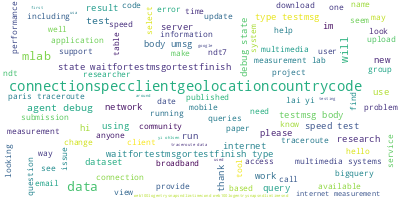

In [5]:
from wordcloud import WordCloud
long_string = ','.join(list(dropped_data['sanitized_content'].values))

wordcloud = WordCloud(background_color="white", contour_width=5, contour_color='steelblue')

wordcloud.generate(long_string)

wordcloud.to_image()



Now we get into the meat and potatoes! This next step will handle: Tokenization -> Removing Stopwords -> generate corpus

In [9]:
from nltk.corpus import stopwords
import nltk
import gensim
from gensim.utils import simple_preprocess
nltk.download('stopwords')
import gensim.corpora as corpora

stop_words = set(stopwords.words('english'))

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
data = dropped_data.sanitized_content.values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30]) # just to see how its working

# Create Dictionary
id2word = corpora.Dictionary(data_words)
print(id2word)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])



[nltk_data] Downloading package stopwords to
[nltk_data]     /home/quinton/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['hi', 'im', 'looking', 'monthly', 'average', 'mobile', 'download', 'speed', 'data', 'country', 'specifcally', 'onwards', 'earlier', 'better', 'though', 'far', 'ive', 'able', 'find', 'data', 'anyone', 'help', 'id', 'really', 'greatful', 'advice', 'thanks', 'advance']
Dictionary<4722 unique tokens: ['able', 'advance', 'advice', 'anyone', 'average']...>
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1)]
